<a href="https://colab.research.google.com/github/shengwenLeong/Colab/blob/main/GraphSSSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist, squareform

In [32]:
class ConstructKnnGraph:
  def __init__(self, vertex_number, k_value):
    self.G = nx.DiGraph()
    self.vertex_number = vertex_number
    self.k_value = k_value
  
  def KnnGraph(self):
    data = np.random.rand(self.vertex_number,2)
    for i in range(data.shape[0]):
      self.G.add_node(i, pos=(data[i][0], data[i][1]))
      self.G.add_node(i, prop=1)
      self.G.add_node(i, accum=0)
    for i in range(data.shape[0]):
      query = data[i]
      dist = {}
      for t in range(data.shape[0]):
        if t==i:
          continue
        dist[t] = np.linalg.norm(data[t] - query)
        #print("query={}, nn={}, distance={}".format(i,t,dist))
      vertexSort = sorted(dist.items(), key=lambda dist:dist[1], reverse=False)[:self.k_value]
      for vertex in vertexSort:
        self.G.add_edge(i, vertex[0])
        #print("edge=({},{})".format(i, vertex[0]))
  def DrawGraph(self):
    node_pos = nx.get_node_attributes(self.G, 'pos')
    nx.draw_networkx(self.G, node_pos)
    # Show the plot
    plt.show()

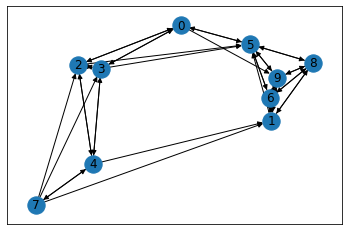

In [44]:
KGraph = ConstructKnnGraph(10, 4)
KGraph.KnnGraph()
KGraph.DrawGraph()

In [113]:
import sys
MAX_PROP = sys.maxsize - 1
class GraphFramework:
  def __init__(self, inputGraph):
    self.G = inputGraph
    self.edges = self.G.edges()
    self.update = []
    self.vertex = self.G.nodes()
    self.BIT_MASK = 0x80000000
  
  def initProperty(self, srcProp):
    return srcProp #the level of bfs

  def reset_nodes_attribute(self):
    for i in self.vertex:
      self.G.add_node(i, accum=MAX_PROP)

  def Scatter(self, edgeProp=None, srcProp=None):
    if ((srcProp & self.BIT_MASK) == self.BIT_MASK):
      print("enter this scatter stage")
      result = (srcProp) + (edgeProp)
      if result > MAX_PROP:
        return MAX_PROP
      else:
        return result
    else:
      return (srcProp) + (edgeProp)

  def Gather(self, ori, dst_value):
    if ((((ori & ~self.BIT_MASK) > (dst_value & ~self.BIT_MASK)) and (dst_value != 0)) or (ori == 0x0)):
      return dst_value
    else:
      return ori
    #return ((((ori & ~self.BIT_MASK) > (dst_value & ~self.BIT_MASK)) && (dst_value != 0)) || (ori == 0x0)) ? (dst_value) : (ori)

  def Apply(self, accum, value):
    update = 0
    uProp = accum
    wProp = 0
    if (((value & self.BIT_MASK) == self.BIT_MASK) and (uProp == MAX_PROP)):
      print("enter this stage")
      iter = 1
      wProp = value
    else:
      iter = 0
      wProp = uProp & 0x7FFFFFFF
    update = wProp
    return iter, update


  def run(self):
    iter = 1
    count = 0
    while iter and count < 5:
      for src, dst in self.edges:
        srcProp  = self.G.nodes[src]['prop']
        srcProp  = self.initProperty(srcProp)
        edgeProp = G.get_edge_data(src, dst)['weight']
        dst_value = self.Scatter(edgeProp=edgeProp, srcProp=srcProp)
        print("edge=({},{}) edgeProp={}, srcProp={} dst_value={}".format(src,dst,edgeProp,srcProp,dst_value))
        self.update.append((src, dst, dst_value))
      print("-------------")
      #self.reset_nodes_attribute()
      for src, dst, dst_value in self.update:
        print("update=({},{})".format(src, dst))
        ori = self.G.nodes[dst]['accum']
        print("input value=({},{})".format(ori, dst_value))
        accum = self.Gather(ori, dst_value)
        print("dst={}, accum=({})".format(dst, accum))
        self.G.add_node(dst, accum=accum)
      print("-------------")
      iter = 0
      for v in self.vertex:
        accum = self.G.nodes[v]['accum']
        value = self.G.nodes[v]['prop']
        print("vertex={}, apply_input=({},{})".format(v,accum,value))
        iter_, result = self.Apply(accum, value)
        print("vertex={},iter_={},apply={}".format(v,iter_,result))
        self.G.nodes[v]['prop'] = result
        iter = iter + iter_
      print("-------------")
      self.update.clear()
      print(list(self.G.nodes(data=True)))
      for i, value in nx.get_node_attributes(self.G, 'prop').items():
        print("i={}, distance={}".format(i, value))
      count = count + 1

In [115]:
G = nx.DiGraph()
for i in range(7):
  G.add_node(i, prop=MAX_PROP)
  G.add_node(i, accum=0)
G.add_edge(0, 1, weight=4);
G.add_edge(1, 2, weight=1);
G.add_edge(1, 3, weight=3);
G.add_edge(1, 4, weight=5);
G.add_edge(2, 5, weight=6);
G.add_edge(3, 5, weight=2);
G.add_edge(4, 5, weight=4);
G.add_edge(5, 6, weight=4);
'''
G.add_edge(0, 1, weight=4);
G.add_edge(0, 7, weight=8);
G.add_edge(1, 2, weight=8);
G.add_edge(1, 7, weight=11);
G.add_edge(2, 3, weight=7);
G.add_edge(2, 8, weight=2);
G.add_edge(2, 5, weight=4);
G.add_edge(3, 4, weight=9);
G.add_edge(3, 5, weight=14);
G.add_edge(4, 5, weight=10);
G.add_edge(5, 6, weight=2);
G.add_edge(6, 7, weight=1);
G.add_edge(6, 8, weight=6);
G.add_edge(7, 8, weight=7);
'''
root = 0
edges = nx.single_source_dijkstra_path_length(G, source=root)
print(edges)

G.add_node(0, prop=0x80000001)
G.add_node(0, accum=0x80000001)
graphprocess = GraphFramework(G)
graphprocess.run()

for i, value in nx.get_node_attributes(G, 'prop').items():
  print("i={}, distance={}".format(i, value - 1))

{0: 0, 1: 4, 2: 5, 3: 7, 4: 9, 5: 9, 6: 13}
enter this scatter stage
edge=(0,1) edgeProp=4, srcProp=2147483649 dst_value=2147483653
enter this scatter stage
edge=(1,2) edgeProp=1, srcProp=9223372036854775806 dst_value=9223372036854775806
enter this scatter stage
edge=(1,3) edgeProp=3, srcProp=9223372036854775806 dst_value=9223372036854775806
enter this scatter stage
edge=(1,4) edgeProp=5, srcProp=9223372036854775806 dst_value=9223372036854775806
enter this scatter stage
edge=(2,5) edgeProp=6, srcProp=9223372036854775806 dst_value=9223372036854775806
enter this scatter stage
edge=(3,5) edgeProp=2, srcProp=9223372036854775806 dst_value=9223372036854775806
enter this scatter stage
edge=(4,5) edgeProp=4, srcProp=9223372036854775806 dst_value=9223372036854775806
enter this scatter stage
edge=(5,6) edgeProp=4, srcProp=9223372036854775806 dst_value=9223372036854775806
-------------
update=(0,1)
input value=(0,2147483653)
dst=1, accum=(2147483653)
update=(1,2)
input value=(0,922337203685477580